<a href="https://colab.research.google.com/github/INIT-FIU-Hardware-Build-Spring2024/ASL-Glove/blob/main/MLP_version2_WIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CV Accuracies: [0.9975    1.        1.        0.9924812 1.       ] Mean: 0.9979962406015037
Test acc: 0.9975
              precision    recall  f1-score   support

        Dale       1.00      0.99      0.99       100
    ILoveYou       1.00      1.00      1.00       150
     Paws_Up       0.99      1.00      1.00       150

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

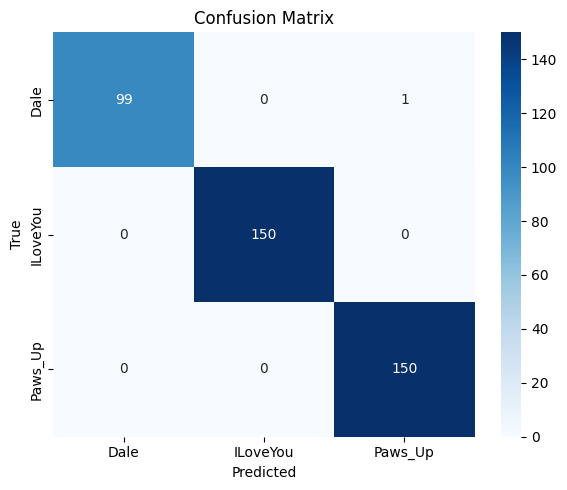

<ipython-input-35-5ea81adba3cd>:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


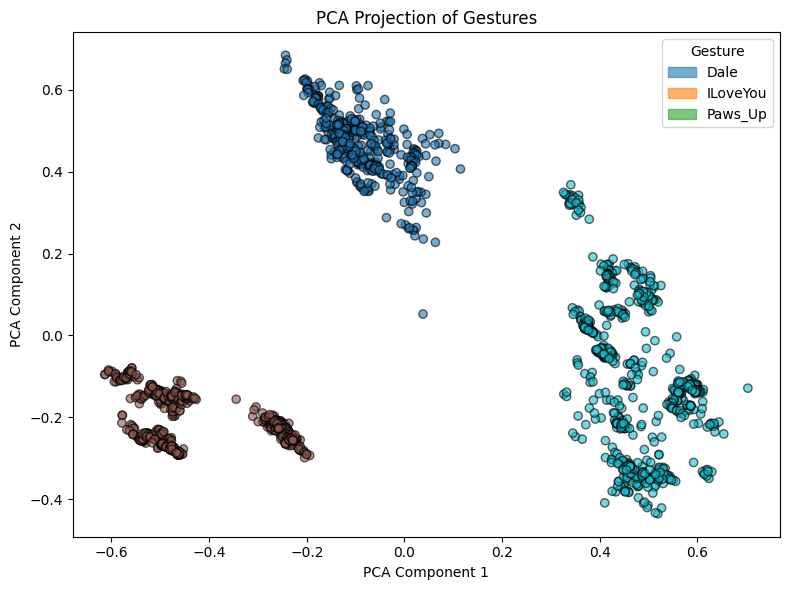

In [ ]:
# Colab: train_model.ipynb
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import joblib
from google.colab import files
from sklearn.decomposition import PCA

# 1. Load your PRE‑NORMALIZED data
df1 = pd.read_csv("ILoveYou_data.csv")   # values already normalized
df2 = pd.read_csv("Paws_Up_data.csv")
df3 = pd.read_csv("Dale_data.csv")

# 2. Combine & clean
df = pd.concat([df1, df2, df3], ignore_index=True)
for col in df.columns:
    if col != "Gesture":
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col].median())
df = df.dropna(subset=["Gesture"])

# 3. Split features/labels
X = df.drop("Gesture", axis=1).astype(np.float32)
y = df["Gesture"]

# 4. Encode gestures
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# 5. Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 6. Define & cross‑validate your MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(128,64),
    activation='relu',
    solver='adam',
    max_iter=500,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=42
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlp, X_scaled, y_encoded, cv=skf, scoring='accuracy')
print("CV Accuracies:", cv_scores, "Mean:", cv_scores.mean())

# 7. Train/test split & final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("Test acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# 8. Save your artifacts
joblib.dump(mlp, "gesture_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, "label_encoder.pkl")

# 9. Download
files.download("gesture_model.pkl")
files.download("scaler.pkl")
files.download("label_encoder.pkl")

# -------------------------------
# 10. Plot Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# -------------------------------
# 11. PCA Visualization
# -------------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Make scatter
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y_encoded,
    cmap='tab10',
    alpha=0.6,
    edgecolor='k'
)

ax.set_title("PCA Projection of Gestures")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")

# Create proxy artists and labels manually
cmap = plt.cm.get_cmap('tab10')
proxies = []   # list of Patch objects
labels  = []   # the string labels for the legend

for idx, class_label in enumerate(encoder.classes_):
    color = cmap(idx)           # RGBA tuple for this class
    patch = Patch(color=color, alpha=0.6, label=class_label)
    proxies.append(patch)
    labels.append(class_label)

# Add the legend
ax.legend(
    handles=proxies,
    labels=labels,
    title="Gesture",
    loc='best'            # or any location you prefer
)

plt.tight_layout()
plt.show()
